## What is the body forcing doing?

The external forcing in my runs (TracerExperiments) consists of a body force that has a similar effect to varying the rotation rate of the rotating table.

The force ramps up over the short time (ST) setting, then Umaxis applied over the forcing time (FT). After forcing time has run out, zero forcing is applied and spindown occurs.

**Parameters**:

FT = 86400     (seconds) Time Umax forcing is applied

ST = 86400     (seconds) Short time, ramp up time

Umax = 0.315   (m/s) Max. Velocity U-dir at coast, positive means upwelling favorable

sr = 0.15      Final, steady foricng ratio

gUmax = Umax/(FT+ST/2) Max forcing at coast (acceleration, m/s^2)

alpha = gUmax/ST       slope of forcing

The algorithm is as follows:

For every xi and yi 

Finally, add body forcing to rhs of U tendency:
gU(i,j,kLev,bi,bj) = gU(i,j,kLev,bi,bj)+bf(i,j)


In [1]:
import numpy as np

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import xarray as xr
#import canyon_tools.readout_tools as rdout

#import canyon_tools.metrics_tools as mpt # netcdf module in mitgcmutils is not working


In [2]:
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

In [3]:
# load grid variables
Grid = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc')
GridNoC = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc')
State = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc')

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = Grid.XC # x coords tracer cells
yc = Grid.YC # y coords tracer cells
rc = Grid.RC
z = State.Z
times = State.T

bathy = Grid.Depth

hFacC = Grid.HFacC
MaskC = Grid.HFacC

rA = GridNoC.rA
drF = GridNoC.drF # vertical distance between faces
drC = GridNoC.drC # vertical distance between centers
dxf = GridNoC.dxF

hFacCNoC = GridNoC.HFacC
mask_NoC = GridNoC.HFacC


In [4]:
# Forcing parameters

FT = 86400.0     # (seconds) Time Umax forcing is applied

ST = 86400.0     # (seconds) Short time, ramp up time

Umax = 0.315   # (m/s) Max. Velocity U-dir at coast, positive means upwelling favorable

sr = 0.15      # Final, steady forcing ratio

gUmax = Umax/(FT+(ST/2.0)) # Max forcing at coast (acceleration, m/s^2)

alpha = gUmax/ST       # slope of forcing

In [5]:
time = np.linspace(0,86400*9.0,1000)

time1 = time[time < ST]
time2 = time[(ST < time) & (time < ST+FT)]
time3 = time[(ST+FT< time) & (time < FT+(2.0-sr)*ST)]
time4 = time[time > FT+(2.0-sr)*ST]


In [19]:
def bfST(yy, time1):
    bfST= alpha*time1*(yy/(90000.0-35000.0))  # time < ST
    return bfST
    
def bfFT(yy, time2):
    bfFt =  alpha*ST*np.ones(np.shape(time2))*(yy/(90000.0-35000.0))    # ST < time < FT\
    return bfFt

def bfsr(yy,time3):
    bfsr= alpha*(FT+(2*ST)-time3)*(yy /(90000.0-35000.0)) # time < FT+(2-sr)*ST
    return bfsr

def bf(yy,time4):
    bf = sr*alpha*ST*np.ones(np.shape(time4))*(yy/(90000.0-35000.0))
    return bf


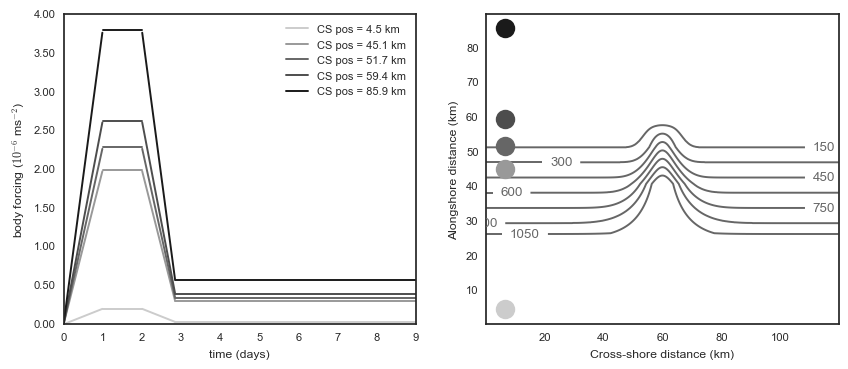

In [21]:
from matplotlib.ticker import FormatStrFormatter
sns.set_context('paper')
sns.set_style('white')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.plot(time1/86400.0,bfST(yc[10,10].data,time1)*1E6, color='0.8', label = ('CS pos = %1.1f km' %(yc[10,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[10,10].data,time2)*1E6, color='0.8')
ax1.plot(time3/86400.0,bfsr(yc[10,10].data,time3)*1E6, color='0.8')
ax1.plot(time4/86400.0,bf(yc[10,10].data,time4)*1E6, color='0.8')

ax1.plot(time1/86400.0,bfST(yc[180,10].data,time1)*1E6, color='0.6', label = ('CS pos = %1.1f km' %(yc[180,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[180,10].data,time2)*1E6, color='0.6')
ax1.plot(time3/86400.0,bfsr(yc[180,10].data,time3)*1E6, color='0.6')
ax1.plot(time4/86400.0,bf(yc[180,10].data,time4)*1E6, color='0.6')

ax1.plot(time1/86400.0,bfST(yc[227,10].data,time1)*1E6, color='0.4', label = ('CS pos = %1.1f km' %(yc[227,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[227,10].data,time2)*1E6, color='0.4')
ax1.plot(time3/86400.0,bfsr(yc[227,10].data,time3)*1E6, color='0.4')
ax1.plot(time4/86400.0,bf(yc[227,10].data,time4)*1E6, color='0.4')

ax1.plot(time1/86400.0,bfST(yc[267,10].data,time1)*1E6, color='0.3', label = ('CS pos = %1.1f km' %(yc[267,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[267,10].data,time2)*1E6, color='0.3')
ax1.plot(time3/86400.0,bfsr(yc[267,10].data,time3)*1E6, color='0.3')
ax1.plot(time4/86400.0,bf(yc[267,10].data,time4)*1E6, color='0.3')

ax1.plot(time1/86400.0,bfST(yc[350,10].data,time1)*1E6, color='0.1', label = ('CS pos = %1.1f km' %(yc[350,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[350,10].data,time2)*1E6, color='0.1')
ax1.plot(time3/86400.0,bfsr(yc[350,10].data,time3)*1E6, color='0.1')
ax1.plot(time4/86400.0,bf(yc[350,10].data,time4)*1E6, color='0.1')

ax1.legend(loc = 0)
ax1.set_ylabel('body forcing ($10^{-6}$ ms$^{-2}$)')
ax1.set_xlabel('time (days)')

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,8, colors = '0.4')
ax2.clabel(cntr,fmt='%0.0f')
ax2.plot(xc[1,10]/1000.0,yc[10,10]/1000.0,'o',color='0.8',markersize = 14)
ax2.plot(xc[180,10]/1000.0,yc[180,10]/1000.0,'o',color='0.6',markersize = 14)
ax2.plot(xc[227,10]/1000.0,yc[227,10]/1000.0,'o',color='0.4',markersize = 14)
ax2.plot(xc[267,10]/1000.0,yc[267,10]/1000.0,'o',color='0.3',markersize = 14)
ax2.plot(xc[350,10]/1000.0,yc[350,10]/1000.0,'o',color='0.1',markersize = 14)

ax2.set_xlabel('Cross-shore distance (km)')
ax2.set_ylabel('Alongshore distance (km)')

plt.savefig('BodyForcing.eps',fomat='eps',bbox_inches='tight')

This forcing is not what I thought it was! Did I change the external forcing file? 

### Along shore velocity

In [61]:
# get u and v components of velocity
Ustag = State.U
UU = unstagger_xarray(Ustag,'Xp1')

In [73]:
def plotU_timeseries(U,times,kk,ii):
    '''
    '''
    sns.set_context('paper')
    sns.set_style('white')

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

    ax1.plot(times[:]/2,U[:,kk,10,ii], color='0.8',linewidth=2, label = ('CS pos = %1.1f km' %(yc[10,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,180,ii], color='0.6',linewidth=2, label = ('CS pos = %1.1f km' %(yc[180,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,227,ii], color='0.4',linewidth=2, label = ('CS pos = %1.1f km' %(yc[227,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,267,ii], color='0.3',linewidth=2, label = ('CS pos = %1.1f km' %(yc[267,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,350,ii], color='0.1', linewidth=2,label = ('CS pos = %1.1f km' %(yc[350,ii]/1000.0)))

    ax1.legend(loc = 0)
    ax1.set_ylabel('Alongshore velocity (m/s)')
    ax1.set_xlabel('time (days)')
    ax1.set_title('at z = %1.1f m' %z[kk])
    ax1.set_ylim(-0.1,0.45)

    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,750,900,1050], colors = '0.4')
    ax2.clabel(cntr)
    ax2.plot(xc[10,ii]/1000.0,yc[10,ii]/1000.0,'o',color='0.8',markersize = 14)
    ax2.plot(xc[180,ii]/1000.0,yc[180,ii]/1000.0,'o',color='0.6',markersize = 14)
    ax2.plot(xc[227,ii]/1000.0,yc[227,ii]/1000.0,'o',color = '0.4',markersize = 14)
    ax2.plot(xc[267,ii]/1000.0,yc[267,ii]/1000.0,'o',color='0.3',markersize = 14)
    ax2.plot(xc[350,ii]/1000.0,yc[350,ii]/1000.0,'o',color='0.1',markersize = 14)
    ax2.set_xlabel('(km)')
    ax2.set_ylabel('(km)')

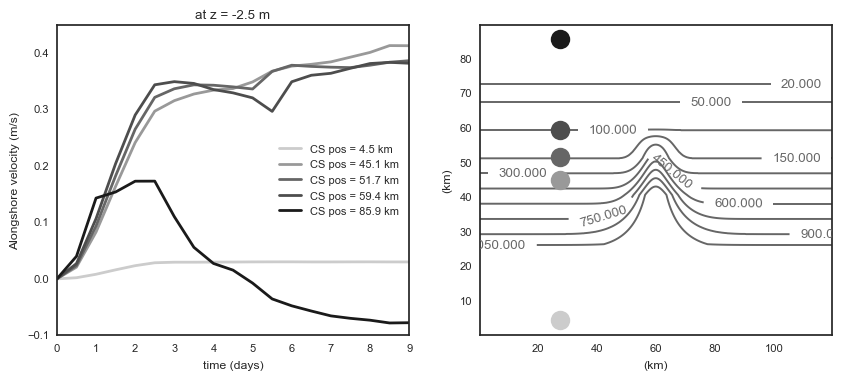

In [65]:
times=np.array(range(19))
plotU_timeseries(Ustag,times,0,50)


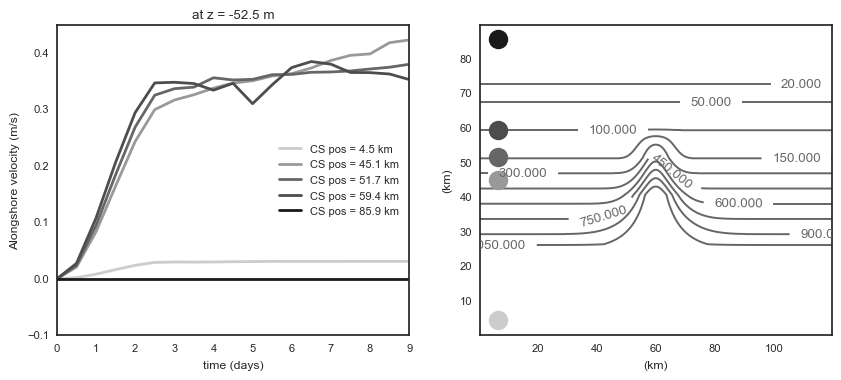

In [66]:
plotU_timeseries(Ustag,times,10,10)

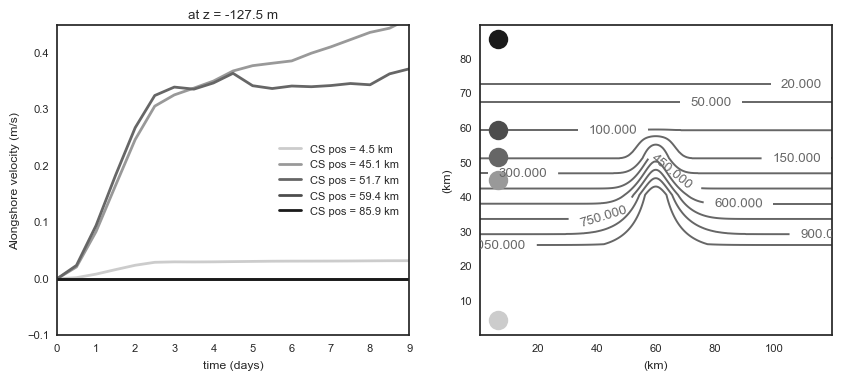

In [67]:
plotU_timeseries(Ustag,times,25,10)

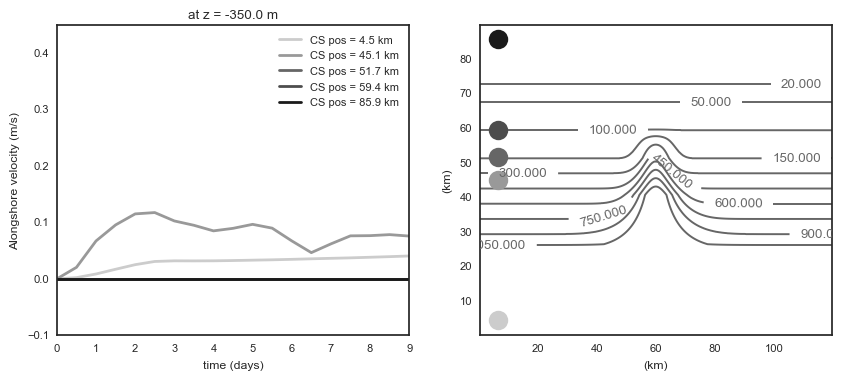

In [68]:
plotU_timeseries(Ustag,times,47,10)

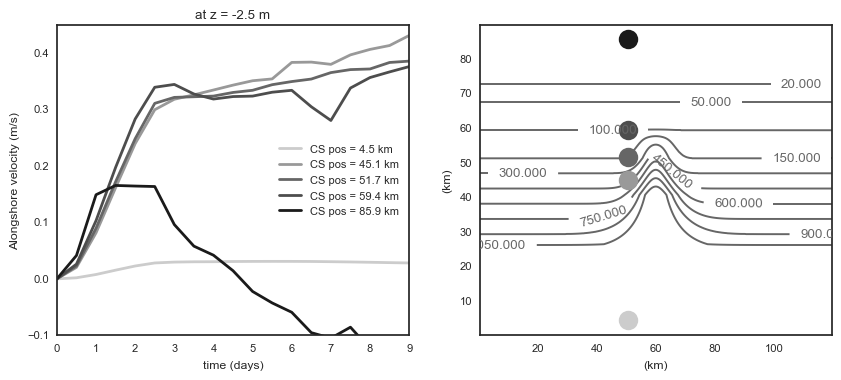

In [69]:
plotU_timeseries(Ustag,times,0,120)

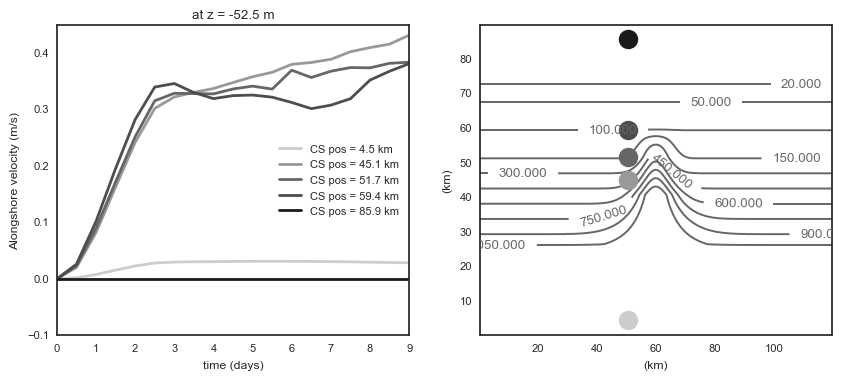

In [70]:
plotU_timeseries(Ustag,times,10,120)

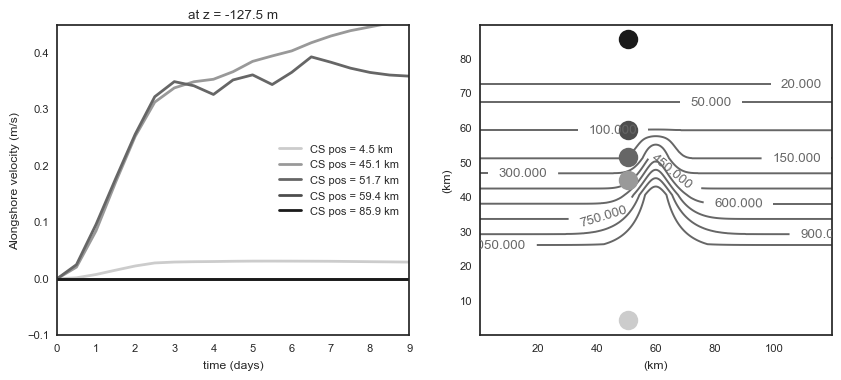

In [71]:
plotU_timeseries(Ustag,times,25,120)

In [75]:
def plotU_timeseries_nomap(U,times,kk,ii):
    '''
    '''
    sns.set_context('paper')
    sns.set_style('white')

    fig,(ax1) = plt.subplots(1,1,figsize=(4,4))

    ax1.plot(times[:]/2,U[:,kk,10,ii], color='0.8',linewidth=2, label = ('CS pos = %1.1f km' %(yc[10,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,180,ii], color='0.6',linewidth=2, label = ('CS pos = %1.1f km' %(yc[180,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,227,ii], color='0.4',linewidth=2, label = ('CS pos = %1.1f km' %(yc[227,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,267,ii], color='0.3',linewidth=2, label = ('CS pos = %1.1f km' %(yc[267,ii]/1000.0)))
    ax1.plot(times[:]/2.0,U[:,kk,350,ii], color='0.1', linewidth=2,label = ('CS pos = %1.1f km' %(yc[350,ii]/1000.0)))

    ax1.legend(loc = 0)
    ax1.set_ylabel('Alongshore velocity (m/s)')
    ax1.set_xlabel('time (days)')
    ax1.set_title('at z = %1.1f m' %z[kk])
    ax1.set_ylim(-0.1,0.45)

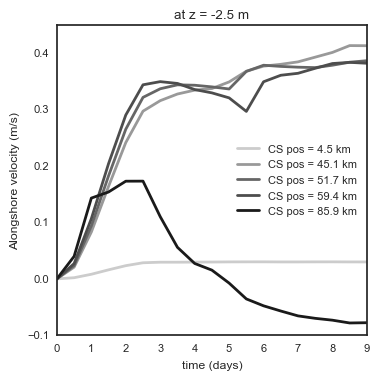

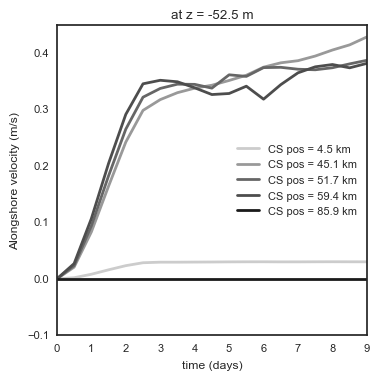

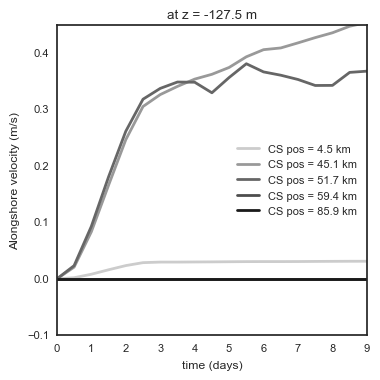

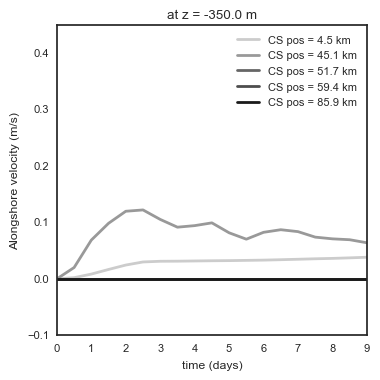

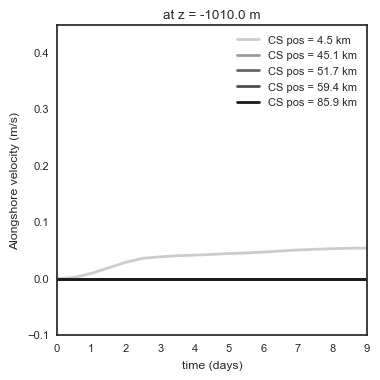

In [79]:
times=np.array(range(19))
plotU_timeseries_nomap(Ustag,times,0,50)
#plt.savefig('U_2p5m_base.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(Ustag,times,10,50)
#plt.savefig('U_52m_base.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(Ustag,times,25,50)
#plt.savefig('U_127m_base.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(Ustag,times,47,50)
#plt.savefig('U_350m_base.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(Ustag,times,80,50)
#plt.savefig('U_1010m_base.eps',fomat='eps',bbox_inches='tight')




## SSH anomaly

Kämpf(2006) forced his runs with ssh. He shows a plot whre there is a clear relationship between upwelling index (wind) and ssh. The way it works is that SSH at the coast is ramped linearly for 2 days and kept constant during 3 days, while ssh at the open ocean boundary is kept at its original value. He changes the forcing by using different values of SSH at the coast.

A SSH anomaly of -10 cm (a drop, equivalent to an upwelling index of 1) generates, in his model, a coastal upwelling jet 0f approx 30 cm/s. 

By the way, all of this is in the Southern Hemisphere.

What is my ssh anomaly?

Kämpf, J. (2006) Transient wind-driven upwelling in a submarine canyon: A process-oriented modeling study, J. Geophys. Res., 111, C11011. 

In [30]:
# Load ssh field
Eta = State.Eta

In [31]:
def contourfEta(Eta,tt1,tt2,tt3,tt4,tt5,tt6,tt7,tt8,tt9):
    '''
    '''
    sns.set_context('paper')
    sns.set_style('white')

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,10), sharex=True, sharey=True)

    cf = ax1.contourf(xc/1000.0,yc/1000.0,Eta[tt1,:,:], 20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax1.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax1.clabel(cntr)
    
    cf = ax2.contourf(xc/1000.0,yc/1000.0,Eta[tt2,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax2.clabel(cntr)
    
    cf = ax3.contourf(xc/1000.0,yc/1000.0,Eta[tt3,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax3.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax3.clabel(cntr)
    
    cf = ax4.contourf(xc/1000.0,yc/1000.0,Eta[tt4,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax4.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax4.clabel(cntr)
    
    cf = ax5.contourf(xc/1000.0,yc/1000.0,Eta[tt5,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax5.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax5.clabel(cntr)
    
    cf = ax6.contourf(xc/1000.0,yc/1000.0,Eta[tt6,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax6.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax6.clabel(cntr)
    
    cf = ax7.contourf(xc/1000.0,yc/1000.0,Eta[tt7,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax7.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax7.clabel(cntr)
    
    cf = ax8.contourf(xc/1000.0,yc/1000.0,Eta[tt8,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax8.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax8.clabel(cntr)
    
    cf9 = ax9.contourf(xc/1000.0,yc/1000.0,Eta[tt9,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax9.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax9.clabel(cntr)
    
    ax1.annotate('Day 1', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    ax9.annotate('Day 9', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    
    cbar_ax = fig.add_axes([0.12, -0.02, 0.8, 0.03])
    fig.colorbar(cf9, cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_xlabel('$\eta$ (m)')
    
    ax4.set_ylabel('(km)')
    ax8.set_xlabel('(km)')
    plt.tight_layout()
    

In [32]:
def plotEta(EtaSlice, times, title):
    '''
    '''
    sns.set_context('paper')
    sns.set_style('white')
    sns.set_palette("GnBu_d",10)
    
    fig,(ax1) = plt.subplots(1,1,figsize=(4,4), sharex=True, sharey=True)
    
    for tt in times:
        ax1.plot(yc[:,1]/1000,EtaSlice[tt,:],linewidth=2,label = 'day %1.1f' %(tt/2))
    
    ax1.set_ylabel('$\eta$ (m)')
    ax1.set_xlabel('Cross-shore distance (km)')
    ax1.set_title(title)
    ax1.legend(loc=0)
    plt.tight_layout()
    

In [ ]:
contourfEta(Eta,2,4,6,8,10,12,14,16,18)

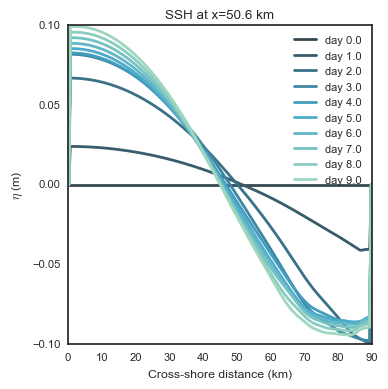

In [46]:
plotEta(Eta[:,:,120], [0,2,4,6,8,10,12,14,16,18], 'SSH at x=%1.1f km' %(xc[1,120]/1000))
#plt.savefig('SSH_x50km_base_case.eps',fomat='eps',bbox_inches='tight')

SSH keeps getting deeper at the coast and higher at the open ocean as the simulation evolves. What is that zero at the boundaries?

## FORCING_SPNDN
### New experiment in TracerExperiments

New executable mitgcmuv compiled with external_forcing.F with a body forcing that does what I originally thought the first one was doing: Ramp up force during day 1, keep constant during day 2, stop forcing for the rest of the simulation.

In [47]:
# Forcing parameters

FT = 86400.0     # (seconds) Time Umax forcing is applied

ST = 86400.0     # (seconds) Short time, ramp up time

Umax = 0.315   # (m/s) Max. Velocity U-dir at coast, positive means upwelling favorable

sr = 0.0      # Final, steady forcing ratio

gUmax = Umax/(FT+(ST/2.0)) # Max forcing at coast (acceleration, m/s^2)

alpha = gUmax/ST       # slope of forcing

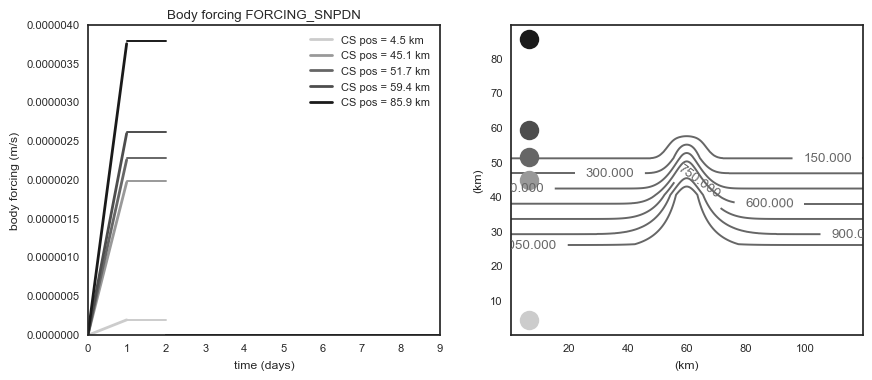

In [50]:
time = np.linspace(0,86400*9.0,1000)

time1 = time[time < ST]
time2 = time[(ST < time) & (time < ST+FT)]
time3 = time[time > ST+FT]


def bfST(yy, time1):
    bfST= alpha*time1*(yy/(90000.0-35000.0))  # time < ST
    return bfST
    
def bfFT(yy, time2):
    bfFt =  alpha*ST*np.ones(np.shape(time2))*(yy/(90000.0-35000.0))    # ST < time < FT\
    return bfFt

def bf(yy,time3):
    bf = sr*alpha*ST*np.ones(np.shape(time3))*(yy/(90000-35000))
    return bf

sns.set_context('paper')
sns.set_style('white')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.plot(time1/86400.0,bfST(yc[10,10].data,time1), color='0.8',linewidth=2, label = ('CS pos = %1.1f km' %(yc[10,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[10,10].data,time2), color='0.8')
ax1.plot(time3/86400.0,bf(yc[10,10].data,time3), color='0.8')


ax1.plot(time1/86400.0,bfST(yc[180,10].data,time1), color='0.6',linewidth=2, label = ('CS pos = %1.1f km' %(yc[180,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[180,10].data,time2), color='0.6')
ax1.plot(time3/86400.0,bf(yc[180,10].data,time3), color='0.6')


ax1.plot(time1/86400.0,bfST(yc[227,10].data,time1), color='0.4',linewidth=2, label = ('CS pos = %1.1f km' %(yc[227,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[227,10].data,time2), color='0.4')
ax1.plot(time3/86400.0,bf(yc[227,10].data,time3), color='0.4')

ax1.plot(time1/86400.0,bfST(yc[267,10].data,time1), color='0.3',linewidth=2, label = ('CS pos = %1.1f km' %(yc[267,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[267,10].data,time2), color='0.3')
ax1.plot(time3/86400.0,bf(yc[267,10].data,time3), color='0.3')

ax1.plot(time1/86400.0,bfST(yc[350,10].data,time1), color='0.1',linewidth=2, label = ('CS pos = %1.1f km' %(yc[350,10]/1000.0)))
ax1.plot(time2/86400.0,bfFT(yc[350,10].data,time2),color='0.1' )
ax1.plot(time3/86400.0,bf(yc[350,10].data,time3), color='0.1')


ax1.legend(loc = 0)
ax1.set_ylabel('body forcing (m/s)')
ax1.set_xlabel('time (days)')
ax1.set_title('Body forcing FORCING_SNPDN')
cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy, colors = '0.4')
ax2.clabel(cntr)
ax2.plot(xc[1,10]/1000.0,yc[10,10]/1000.0,'o',color ='0.8',markersize = 14)
ax2.plot(xc[180,10]/1000.0,yc[180,10]/1000.0,'o',color ='0.6',markersize = 14)
ax2.plot(xc[227,10]/1000.0,yc[227,10]/1000.0,'o',color ='0.4',markersize = 14)
ax2.plot(xc[267,10]/1000.0,yc[267,10]/1000.0,'o',color ='0.3',markersize = 14)
ax2.plot(xc[350,10]/1000.0,yc[350,10]/1000.0,'o',color='0.1',markersize = 14)

ax2.set_xlabel('(km)')
ax2.set_ylabel('(km)')

In [80]:
# get u and v components of velocity
StateSPNDN = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/FORCING_SPNDN/run01/stateGlob.nc')

UUspn =StateSPNDN.U

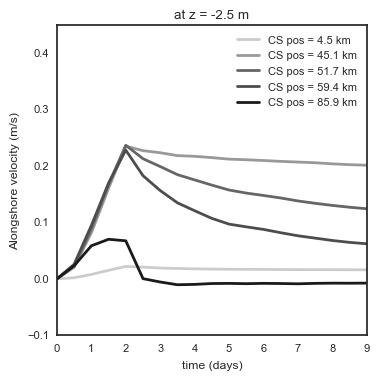

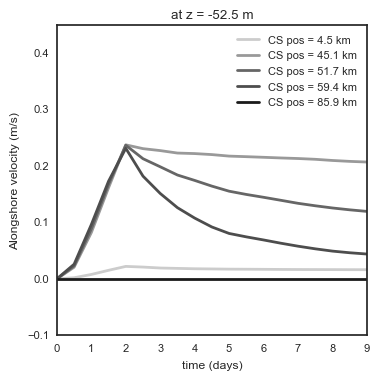

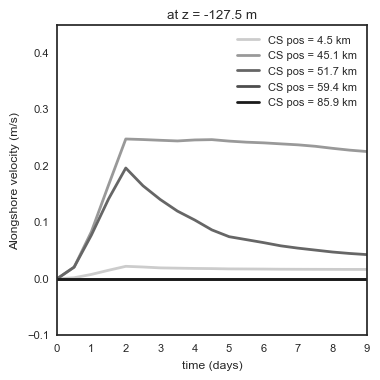

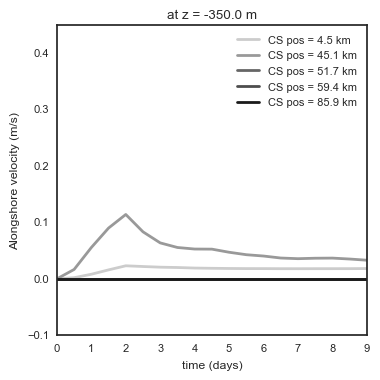

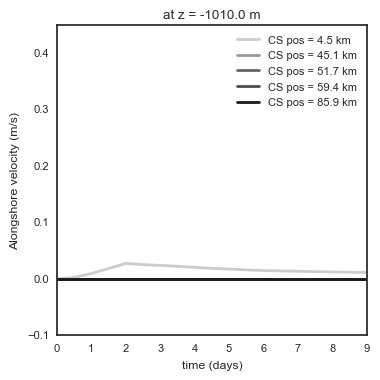

In [81]:
times=np.array(range(19))
plotU_timeseries_nomap(UUspn,times,0,50)
#plt.savefig('U_2p5m_spndn.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UUspn,times,10,50)
#plt.savefig('U_52m_spndn.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UUspn,times,25,50)
#plt.savefig('U_127m_spndn.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UUspn,times,47,50)
#plt.savefig('U_350m_spndn.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UUspn,times,80,50)
#plt.savefig('U_1010m_spndn.eps',fomat='eps',bbox_inches='tight')



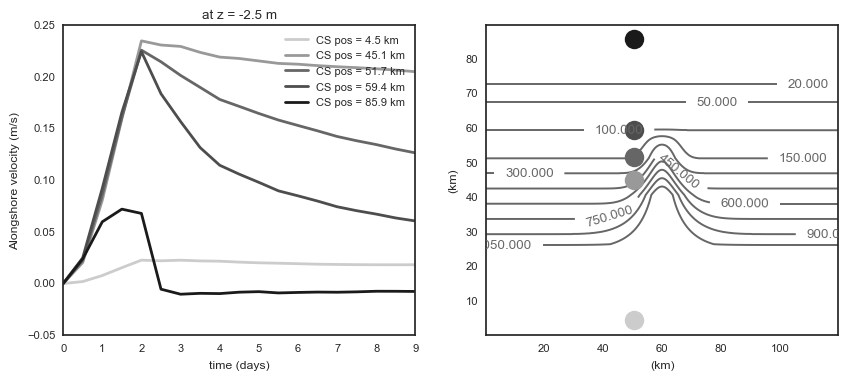

In [52]:
plotU_timeseries(UUspn,times,0,120)

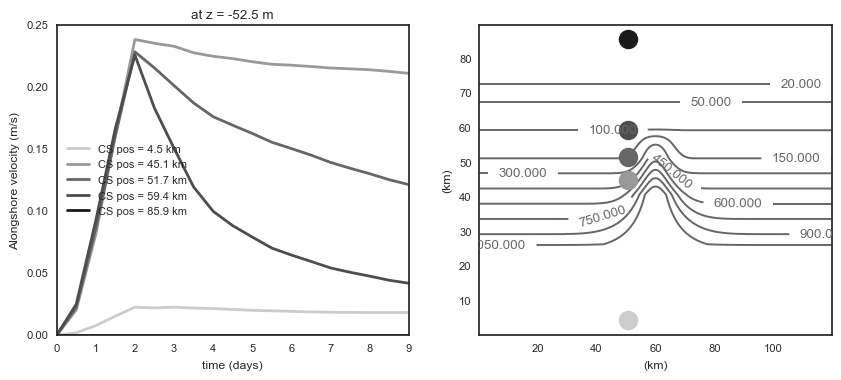

In [53]:
plotU_timeseries(UUspn,times,10,120)

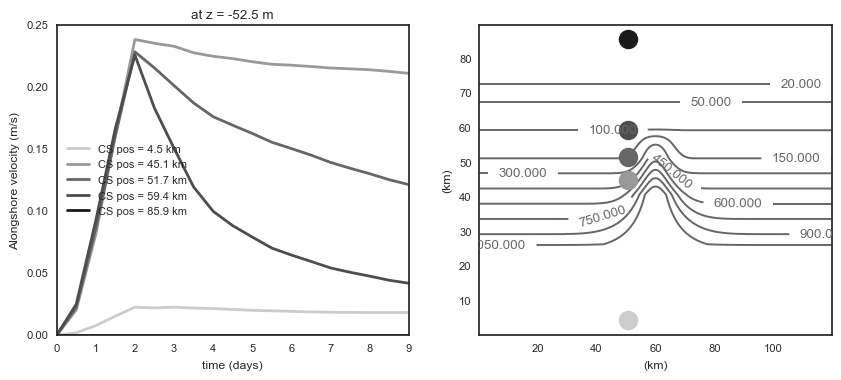

In [54]:
plotU_timeseries(UUspn,times,10,120)

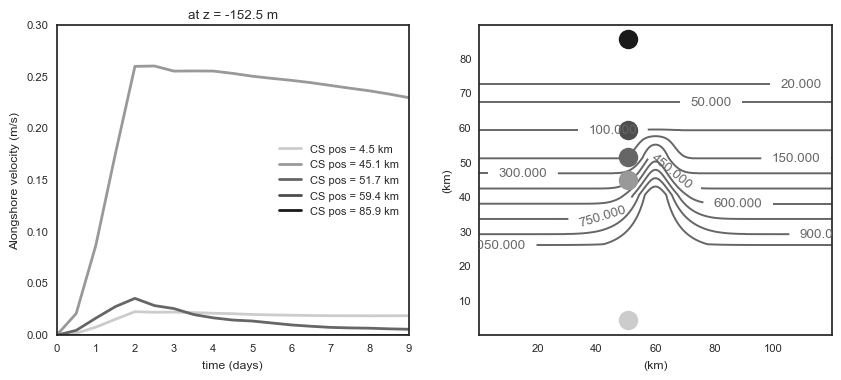

In [55]:
plotU_timeseries(UUspn,times,30,120)

In [56]:
# Load ssh field
Etaspn = StateSPNDN.Eta

In [ ]:
contourfEta(Etaspn,2,4,6,8,10,12,14,16,18)

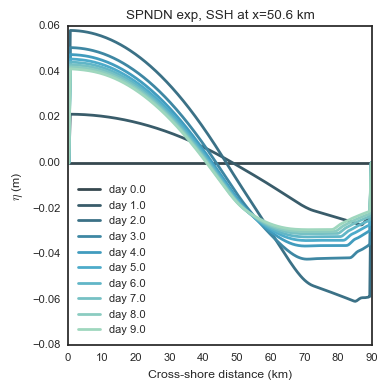

In [59]:
plotEta(Etaspn[:,:,120], [0,2,4,6,8,10,12,14,16,18], 'SPNDN exp, SSH at x=%1.1f km' %(xc[1,120]/1000))
#plt.savefig('SSH_x50km_SpinDown_case.eps',fomat='eps',bbox_inches='tight')

SSH increases until day 2 at open ocean bdy and decreases over coast. Then , slow return to flat top.

## Quick comparison of temperatures

In [ ]:
Temp = State.Temp
Tempspn =StateSPNDN.Temp

In [ ]:

MaskExp = np.expand_dims(MaskC,0)
MaskT = MaskExp + np.zeros(Temp.shape)

Temp_masked = np.ma.masked_array(Temp.data,mask = MaskT) 
Tempspn_masked = np.ma.masked_array(Tempspn.data,mask = MaskT) 

In [ ]:
def contourfTemp(Temp,tt1=2,tt2=4,tt3=6,tt4=8,tt5=10,tt6=12,tt7=14,tt8=16,tt9=18,tmax=17,tmin=0,colormap='rainbow'):
    '''
    '''
    sns.set_context('paper')
    sns.set_style('white')

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,10), sharex=True, sharey=True)

    cf = ax1.contourf(xc/1000.0,yc/1000.0,Temp[tt1,:,:], 20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax1.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax1.clabel(cntr)
    
    cf = ax2.contourf(xc/1000.0,yc/1000.0,Temp[tt2,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax2.clabel(cntr)
    
    cf = ax3.contourf(xc/1000.0,yc/1000.0,Temp[tt3,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax3.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax3.clabel(cntr)
    
    cf = ax4.contourf(xc/1000.0,yc/1000.0,Temp[tt4,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax4.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax4.clabel(cntr)
    
    cf = ax5.contourf(xc/1000.0,yc/1000.0,Temp[tt5,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax5.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax5.clabel(cntr)
    
    cf = ax6.contourf(xc/1000.0,yc/1000.0,Temp[tt6,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax6.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax6.clabel(cntr)
    
    cf = ax7.contourf(xc/1000.0,yc/1000.0,Temp[tt7,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax7.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax7.clabel(cntr)
    
    cf = ax8.contourf(xc/1000.0,yc/1000.0,Temp[tt8,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax8.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax8.clabel(cntr)
    
    cf9 = ax9.contourf(xc/1000.0,yc/1000.0,Temp[tt9,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax9.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax9.clabel(cntr)
    
    ax1.annotate('Day 1', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    ax9.annotate('Day 9', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    
    cbar_ax = fig.add_axes([0.12, -0.02, 0.8, 0.03])
    fig.colorbar(cf9, cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_xlabel('Temperature ($^{\circ}C$)')
    
    ax4.set_ylabel('(km)')
    ax8.set_xlabel('(km)')
    plt.tight_layout()

In [ ]:
print(Temp_masked[3,0,:,:])
#contourfTemp(Temp_masked[:,0,:,:]-Tempspn_masked[:,0,:,:],tmax=0.15,tmin=-0.15,colormap='RdYlBu_r')

In [ ]:
contourfTemp(Temp_masked[:,20,:,:]-Tempspn_masked[:,20,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

In [ ]:
contourfTemp(Temp_masked[:,29,:,:]-Tempspn_masked[:,29,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

In [ ]:
contourfTemp(Temp_masked[:,40,:,:]-Tempspn_masked[:,40,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

## Upwelling differences - vertically integrated tracer along shelf

In [ ]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [ ]:
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
Tr1 = rdout.getField(Ptracers,'Tr1')

PtracersSpn = '/ocean/kramosmu/MITgcm/TracerExperiments/FORCING_SPNDN/run01/ptracersGlob.nc'
Tr1spn = rdout.getField(PtracersSpn,'Tr1')


In [ ]:
HCW,TrMASS = HCW_Tracer_AlongShelf(Tr1,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCWspn,TrMASSspn = HCW_Tracer_AlongShelf(Tr1spn,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)

In [ ]:
sns.set_context('paper')
sns.set_style('white')

fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMASS,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base')
ax1.plot(tt/2.,np.sum(TrMASSspn,axis=1)/1.E14,sns.xkcd_rgb["sapphire"],marker = 'o',label='New forcing')
   
ax2.plot(tt/2.,np.sum(HCW,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base')
ax2.plot(tt/2.,np.sum(HCWspn,axis=1)/1.E10,sns.xkcd_rgb["sapphire"],marker = 'o',label='New forcing')
 
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
plt.tight_layout()

plt.show()

In [ ]:
u_approx=(0.12*9.81)/(90000*9.66E-4)
print(u_approx)

## Forcing with currents at boundaries

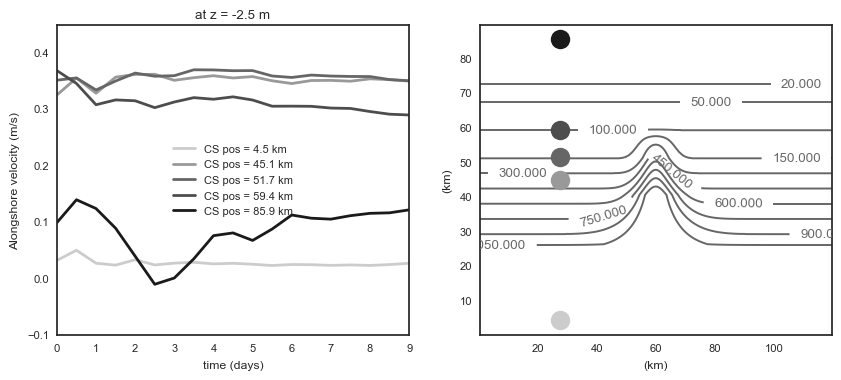

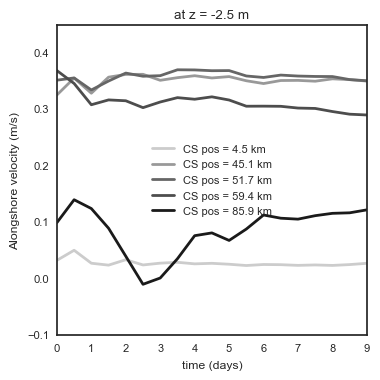

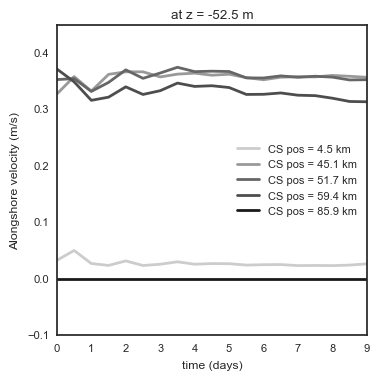

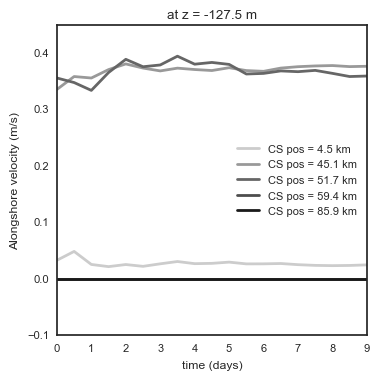

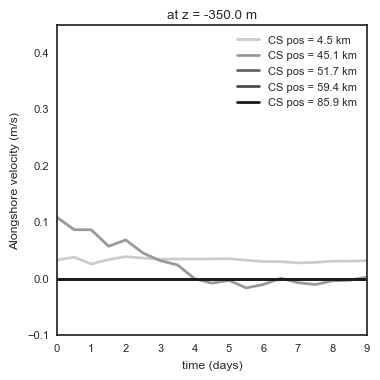

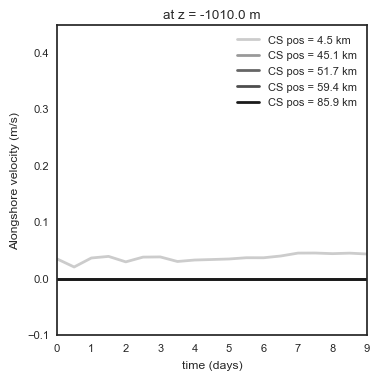

In [82]:
StateNoBF = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run06/stateGlob.nc')

# get u and v components of velocity
UstagNoBf = StateNoBF.U

times=np.array(range(19))
plotU_timeseries(UstagNoBf ,times,0,50)

times=np.array(range(19))
plotU_timeseries_nomap(UstagNoBf ,times,0,50)
#plt.savefig('U_2p5m_EW_OBCS.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UstagNoBf ,times,10,50)
#plt.savefig('U_52m_EW_OBCS.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UstagNoBf ,times,25,50)
#plt.savefig('U_127m_EW_OBCS.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UstagNoBf ,times,47,50)
#plt.savefig('U_350m_EW_OBCS.eps',fomat='eps',bbox_inches='tight')

plotU_timeseries_nomap(UstagNoBf ,times,80,50)
#plt.savefig('U_1010m_EW_OBCS.eps',fomat='eps',bbox_inches='tight')


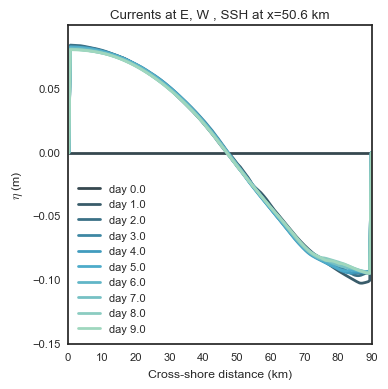

In [83]:
Eta_EW = StateNoBF.Eta
plotEta(Eta_EW[:,:,120], [0,2,4,6,8,10,12,14,16,18], 'Currents at E, W , SSH at x=%1.1f km' %(xc[1,120]/1000))
#plt.savefig('SSH_x50km_EW_OBCS_case.eps',fomat='eps',bbox_inches='tight')